In [ ]:
#check real sigmadat


In [6]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from tqdm.auto import trange
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import kwant
from numpy import sqrt
import scipy
from numba import njit

In [96]:
def op(c,Nimpurities,poles):
    posimp=[int(2*poles/Nimpurities*i) for i in range(Nimpurities)]
    impn=[sum([c[posimp[k]+i].dag() * c[posimp[k]+i] for i in range(2)]) for k in range(Nimpurities)]
    bathn=[[sum([c[2 * j + i + 2+posimp[k]].dag() * c[2 * j + i + 2+posimp[k]] for i in range(2)]) for j in range(int(poles/Nimpurities)-1)] for k in range(Nimpurities)]
    crossn=[[sum([c[posimp[k]+i].dag() * c[2 * j + i + 2+posimp[k]] + c[2 * j + i + 2+posimp[k]].dag() * c[posimp[k]+i] for i in range(2)]) for j in range(int(poles/Nimpurities)-1)] for k in range(Nimpurities)]
    Un=sum([c[posimp[k]].dag() * c[posimp[k]] * c[posimp[k]+1].dag() * c[posimp[k]+1] for k in range(Nimpurities)])
    Sigman=sum([c[posimp[k]].dag() * c[posimp[k]] + c[posimp[k]+1].dag() * c[posimp[k]+1] for k in range(Nimpurities)])

    U2n=0
    for k in range(Nimpurities):
        for l in range(Nimpurities):
            if k !=l:
                for i in range(2):
                    for j in range(2):
                        U2n += (c[posimp[k]+i].dag() * c[posimp[k]+i] * c[posimp[l]+j].dag() * c[posimp[l]+j])
    return impn,crossn,bathn,Un,Sigman,U2n

In [97]:
poles=6
Nimpurities=2

c=[Jordan_wigner_transform(i, 2*poles) for i in range(2*poles)]

impn,crossn,bathn,Un,Sigman,U2n=op(c,Nimpurities,poles)

In [98]:
U2n

Quantum object: dims = [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]], shape = (4096, 4096), type = oper, isherm = True
Qobj data =
[[8. 0. 0. ... 0. 0. 0.]
 [0. 8. 0. ... 0. 0. 0.]
 [0. 0. 8. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

In [7]:
def Jordan_wigner_transform(j, lattice_length):
    """Jordan_wigner_transform(j, lattice_length). 
Defines the Jordan Wigner transformation for a 1D lattice."""
    operators = sigmaz()
    for _ in range(j-1): operators = tensor(operators, sigmaz())
    if j == 0: operators = sigmam()
    else: operators = tensor(operators, sigmam())
    for _ in range(lattice_length - j - 1): operators = tensor(operators, identity(2))
    return operators

@njit
def Startrans(poles,select,omega, eta,row=0):
    """Startrans(poles,select,row,omega, eta). 
Function to transform 1D lattice matrices in order to calculates parameters impengergy, bathenergy and Vkk from random sampling distribution."""
    Pbath,Dbath,pbar,G=np.zeros((poles, poles)),np.zeros((poles,poles)),np.zeros((poles, poles)),np.zeros(omega.shape,dtype = 'complex_')
    for i in range(poles-1):
        for j in range(poles-1):
            if j>=i: Pbath[i+1][j+1]=-1/sqrt((poles-i-1)*(poles-i))
        Pbath[i+1][i]=sqrt(poles-i-1)/sqrt(poles-i)
    Pbath[row,:]=1/sqrt(poles)
    for i, _ in enumerate(select): Dbath[i][i]=select[i]
    pbar[1:,1:]=np.linalg.eig((Pbath@Dbath@Pbath.T)[1:,1:])[1]
    pbar[row][row]=1
    for i, _ in enumerate(select): G+=1 / len(select) / (omega - select[i] + 1.j * eta)
    return pbar.T@Pbath@Dbath@Pbath.T@pbar,G,select

def HamiltonianAIM(c, impenergy, bathenergy, Vkk, U, Sigma, H0 = 0):
    """HamiltonianAIM(c, impenergy, bathenergy, Vkk, U, Sigma). 
Based on energy parameters calculates the Hamiltonian of a single-impurity system."""
    for i in range(2):
        H0 += impenergy * (c[i].dag() * c[i])
        for j, bathE in enumerate(bathenergy):
            H0 += Vkk[j] * (c[i].dag() * c[2 * j + i + 2] + c[2 * j + i + 2].dag() * c[i])+ bathE * (c[2 * j + i + 2].dag() * c[2 * j + i + 2])
    return H0,H0+U * (c[0].dag() * c[0] * c[1].dag() * c[1])-Sigma * (c[0].dag() * c[0] + c[1].dag() * c[1])

@njit
def MBGT0(omega,eta,evals,exp,exp2):
    G=np.zeros(len(omega),dtype = 'complex_')
    for i,expi in enumerate(exp): G+=abs(expi)** 2 / (omega + evals[i+1] - evals[0] + 1.j * eta) + abs(exp2[i])** 2 / (omega + evals[0] - evals[i+1] + 1.j * eta)
    return G

@njit
def MBGTnonzero(omega,eta,evals,exp,exp2,eevals):
    G=np.zeros(len(omega),dtype = 'complex_')
    for i,evi in enumerate(evals):
        for j,evj in enumerate(evals):
            G+=(exp[i][j]*exp2[j][i]/ (omega + evi - evj + 1.j * eta) + exp[j][i]*exp2[i][j]/ (omega + evj - evi + 1.j * eta))*eevals[i]
    return G

def MBGAIM(omega, H, c, eta,Tk,Boltzmann,evals=[],evecs=[],etaoffset=1e-4,posoffset=np.zeros(1,dtype='int')):
    """MBGAIM(omega, H, c, eta). 
Calculates the many body Green's function based on the Hamiltonian eigenenergies/-states."""
    if ~np.any(evals): evals, evecs =scipy.linalg.eigh(H.data.toarray())
    if Tk==[0]:
        vecn=np.conj(evecs[:,1:]).T
        exp,exp2=vecn@c[0].data.tocoo()@evecs[:,0],vecn@c[0].dag().data.tocoo()@evecs[:,0]
        return MBGT0(omega,eta,evals,exp,exp2),Boltzmann,evecs[:,0]
    else:
        MGdat,eta[int(np.round(len(eta)/2))+posoffset]=np.ones((len(Tk),len(omega)),dtype = 'complex_'),etaoffset
        for k,T in enumerate(Tk):
            if Boltzmann[k]!=0:
                eevals=np.exp(-evals/T-scipy.special.logsumexp(-evals/T))
                vecn=np.conj(evecs).T
                exp,exp2=vecn@c[0].data.tocoo()@evecs,vecn@c[0].dag().data.tocoo()@evecs
                MGdat[k,:]=MBGTnonzero(omega,eta,evals,exp,exp2,eevals)
        return MGdat.squeeze(),Boltzmann,evecs[:,0]
    
def Constraint(ctype,H0,H,omega,eta,c,n,Tk,Nfin):
    """Constraint(ctype,H0,H,omega,eta,c,n). 
Constraint implementation function for DED method with various possible constraints."""
    if ctype[0]=='s':
        vecs=scipy.linalg.eigh(H0.data.toarray(),eigvals=[0, 0])[1][:,0]
        evals,evecs=scipy.linalg.eigh(H.data.toarray())
        if ctype=='ssn':
            Boltzmann=np.exp(-abs(evals[find_nearest(np.diag(np.conj(evecs).T@n.data@evecs),np.conj(vecs)@n.data@vecs.T)]-evals[0])/Tk)*Nfin.astype('int')
            return MBGAIM(omega, H, c, eta,Tk,Boltzmann,evals, evecs,5e-4,np.array([-2,-1,0,1,2])),True
        else:
            return MBGAIM(omega, H, c, eta,Tk,np.exp(-abs(evals[find_nearest(np.diag(np.conj(evecs).T@n.data@evecs),np.conj(vecs)@n.data@vecs.T)]-evals[0])/Tk),evals, evecs,5e-4,np.array([-2,-1,0,1,2])),True
    elif ctype[0]=='n':
        vecs=scipy.sparse.csr_matrix(np.vstack((scipy.sparse.linalg.eigsh(np.real(H0.data), k=1, which='SA')[1][:,0],
                                                scipy.sparse.linalg.eigsh(np.real(H.data), k=1, which='SA')[1][:,0])))
        exp=np.conj(vecs)@n.data@vecs.T
        if ctype=='n%2' and int(np.round(exp[0,0]))%2==int(np.round(exp[1,1]))%2:
            return MBGAIM(omega, H, c, eta,Tk,np.ones(len(Tk))),True
        elif ctype=='n' and np.round(exp[0,0])==np.round(exp[1,1]):
            return MBGAIM(omega, H, c, eta,Tk,np.ones(len(Tk))),True
        else:
            return (np.zeros(len(omega),dtype = 'complex_'),np.zeros(len(Tk)),np.array([])),False
    elif ctype[0]=='d':
        vecs=scipy.sparse.csr_matrix(np.vstack((scipy.linalg.eigh(H.data.toarray(),eigvals=[0, 0])[1][:,0],
                                                scipy.linalg.eigh(H0.data.toarray(),eigvals=[0, 0])[1][:,0])))
        exp=np.conj(vecs)@n.data@vecs.T
        if ctype=='dn' and np.round(exp[0,0])==np.round(exp[1,1]):
            return MBGAIM(omega, H, c, eta,Tk,np.ones(len(Tk))),True
        else:
            return (np.zeros(len(omega),dtype = 'complex_'),np.zeros(len(Tk)),np.array([])),False
    else:
        return MBGAIM(omega, H, c, eta,Tk,np.ones(len(Tk))),True
    
def GrapheneAnalyzer(imp,fsyst,colorbnd,filename,omega=np.concatenate((-np.logspace(np.log(8)/np.log(1.5),-40,10000,base=1.5),np.logspace(-40,np.log(8)/np.log(1.5),10000,base=1.5))),etaco=[0.02,1e-24],omegastat=100001):
    """GrapheneAnalyzer(imp,fsyst,colorbnd,filename,omega=np.linspace(-8,8,4001),etaco=[0.02,1e-24],omegastat=100001).
Returns data regarding a defined graphene circular structure such as the corresponding Green's function."""
    def plotsize(i): return 0.208 if i == imp else 0.125
    def family_color(i):
        if i == imp: return 'purple'
        elif i<colorbnd: return (31/255,119/255,180/255,255/255)
        else: return (255/255,127/255,14/255,255/255)
    plt.ion()
    plt.rc('legend', fontsize=25)
    plt.rc('font', size=25)
    plt.rc('xtick', labelsize=25)
    plt.rc('ytick', labelsize=25)
    plot=kwant.plot(fsyst,unit=1.2 ,hop_lw=0.05,site_size=plotsize,site_color=family_color,site_lw=0.02,fig_size=[10,8])
    plot.tight_layout()
    plt.show()
    plt.pause(5)
    plt.close()
    (eig,P),eta=scipy.linalg.eigh(fsyst.hamiltonian_submatrix(sparse=False)),etaco[0]*abs(omega)+etaco[1]
    return np.abs(P[imp][:])**2/np.linalg.norm(np.abs(P[imp][:])),[np.sum([(abs(Pv[i])**2)/(omega-eigv+1.j*eta) 
                                    for i,eigv in enumerate(eig)],axis=0) for _,Pv in enumerate(P)][imp],eig,[np.sum([(abs(Pv[i])**2)
                                    /(np.linspace(min(omega),max(omega),omegastat)-eigv+1.j*(etaco[0]*abs(np.linspace(min(omega),max(omega),omegastat))+etaco[1])) 
                                    for i,eigv in enumerate(eig)],axis=0) for _,Pv in enumerate(P)][imp]

def Graphene_main(psi,SPG,eig,SPrho0,N=200000,poles=4,U=3,Sigma=3/2,Ed=-3/2,SizeO=20000,etaco=[0.02,1e-24], ctype='n',Edcalc='',bound=8,eigsel=False,Tk=[0],posb=1):
    """Graphene_main(graphfunc,args,imp,colorbnd,name,N=200000,poles=4,U=3,Sigma=3/2,SizeO=4001,etaco=[0.02,1e-24], ctype='n',Ed='AS',bound=8,eigsel=False). 
The main Graphene nanoribbon DED function simulating the Anderson impurity model on a defined graphene structure for given parameters."""
    omega,AvgSigmadat,selectpcT,selectpT,pbar= np.concatenate((-np.logspace(np.log(bound)/np.log(1.5),-40,int(np.round(SizeO/2)),base=1.5),np.logspace(-40,np.log(bound)/np.log(1.5),int(np.round(SizeO/2)),base=1.5))),np.zeros(SizeO,dtype = 'complex_'),[],[],trange(N,position=posb,leave=False,desc='Iterations',bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
    c,eta,rhoint=[Jordan_wigner_transform(i, 2*poles) for i in range(2*poles)],etaco[0]*abs(omega)+etaco[1],-np.imag(SPrho0)/np.pi*((max(omega)-min(omega))/len(SPrho0))/sum(-np.imag(SPrho0)/np.pi*((max(omega)-min(omega))/len(SPrho0)))
    n,AvgSigmadat,Nfin,nd=sum([c[i].dag()*c[i] for i in range(2*poles)]),np.zeros((len(Tk),SizeO),dtype = 'complex_'),np.zeros(len(Tk),dtype = 'complex_'),np.zeros(len(Tk),dtype = 'complex_')
    while pbar.n<N:
        reset = False
        while not reset:
            if eigsel: NewM,nonG,select=Startrans(poles,np.sort(np.random.choice(eig, poles,p=psi,replace=False)),omega,eta)
            else: NewM,nonG,select=Startrans(poles,np.sort(np.random.choice(np.linspace(-bound,bound,len(rhoint)),poles,p=rhoint,replace=False)),omega,eta)
            H0,H=HamiltonianAIM(c,NewM[0][0],[NewM[k+1][k+1] for k in range(len(NewM)-1)],NewM[0,1:],U,Sigma)
            try: (MBGdat,Boltzmann,Ev0),reset=Constraint(ctype,H0,H,omega,eta,c,n,Tk,np.array([ar<N for ar in Nfin]))
            except (np.linalg.LinAlgError,ValueError,scipy.sparse.linalg.ArpackNoConvergence): (MBGdat,Boltzmann,Ev0),reset=(np.zeros(len(omega),dtype = 'complex_'),np.zeros(len(Tk)),np.array([])),False
            if np.isnan(1/nonG-1/MBGdat+Sigma).any() or np.array([i >= 1000 for i in np.real(1/nonG-1/MBGdat+Sigma)]).any() or np.array([i >= 500 for i in np.abs(1/nonG-1/MBGdat+Sigma)]).any(): reset=False
            selectpT.append(select)
        Nfin,AvgSigmadat,nd=Nfin+Boltzmann,AvgSigmadat+(1/nonG-1/MBGdat+Sigma)*Boltzmann[:,None],nd+np.conj(Ev0).T@(c[0].dag() * c[0] + c[1].dag() * c[1]).data.tocoo()@Ev0*Boltzmann
        selectpcT.append(select)
        if ctype=='sn': pbar.n+=1
        else: pbar.n=int(min(Nfin))
        pbar.refresh()
    pbar.close()
    if Edcalc == 'AS': return (Nfin.squeeze(),np.real(nd/Nfin).squeeze()),(AvgSigmadat/Nfin[:,None]).squeeze(),(-np.imag(1/(1/SPG-AvgSigmadat/Nfin[:,None]+(AvgSigmadat[:,int(np.round(SizeO/2))]/Nfin)[:,None]))/np.pi).squeeze(),-np.imag(SPG)/np.pi,omega,selectpT,selectpcT,pbar.format_dict["elapsed"]
    else: return (Nfin.squeeze(),np.real(nd/Nfin).squeeze()),(AvgSigmadat/Nfin[:,None]).squeeze(),(-np.imag(1/(1/SPG-AvgSigmadat/Nfin[:,None]-Ed))/np.pi).squeeze(),-np.imag(SPG)/np.pi,omega,selectpT,selectpcT,pbar.format_dict["elapsed"]

def Graphenecirclestruct(r=1.5, t=1):
    def circle(pos):
        return pos[0]**2 + pos[1]**2 < r**2
    lat,syst=kwant.lattice.honeycomb(norbs=1),kwant.Builder()
    syst[lat.shape(circle, (0, 0))],syst[lat.neighbors()] = 0,-t
    return syst.finalized()

def DOSplot(fDOS,Lor,omega,name,labels,log=False):
    """DOSplot(fDOS,Lor,omega,name,labels). 
A plot function to present results from the AIM moddeling for a single results with a comparison to the non-interacting DOS."""
    plt.figure(figsize=(10,8))
    plt.rc('legend', fontsize=17)
    plt.rc('font', size=25)
    plt.rc('xtick', labelsize=25)
    plt.rc('ytick', labelsize=25)
    axis_font = {'fontname':'Calibri', 'size':'25'}
    plt.xlim(min(omega), max(omega))
    if not log: plt.gca().set_ylim(bottom=0,top=1.2)
    else: 
        plt.yscale('log')
        plt.gca().set_ylim(bottom=0.0001,top=10)
        plt.gca().set_xticks([-8,-6,-4,-2,0,2,4,6,8], minor=False)
    plt.xlabel("$\\omega$ [-]", **axis_font)
    plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom", rotation=0,labelpad=30,**axis_font)
    plt.plot(omega,Lor, '--r',linewidth=4,label='$\\rho_0$')
    plt.plot(omega,fDOS,'-b',label=labels)
    plt.legend(fancybox=False).get_frame().set_edgecolor('black')
    plt.grid()
    plt.tight_layout()
    plt.draw()
    plt.pause(5)
    plt.close()
    return plt

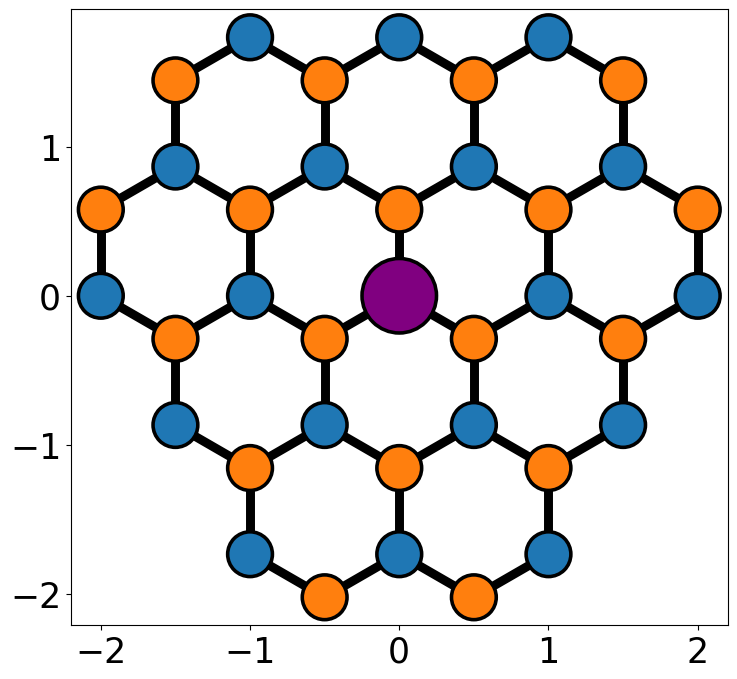

Iterations:   0%|          | 0/1 [00:00<?, ?it/s]

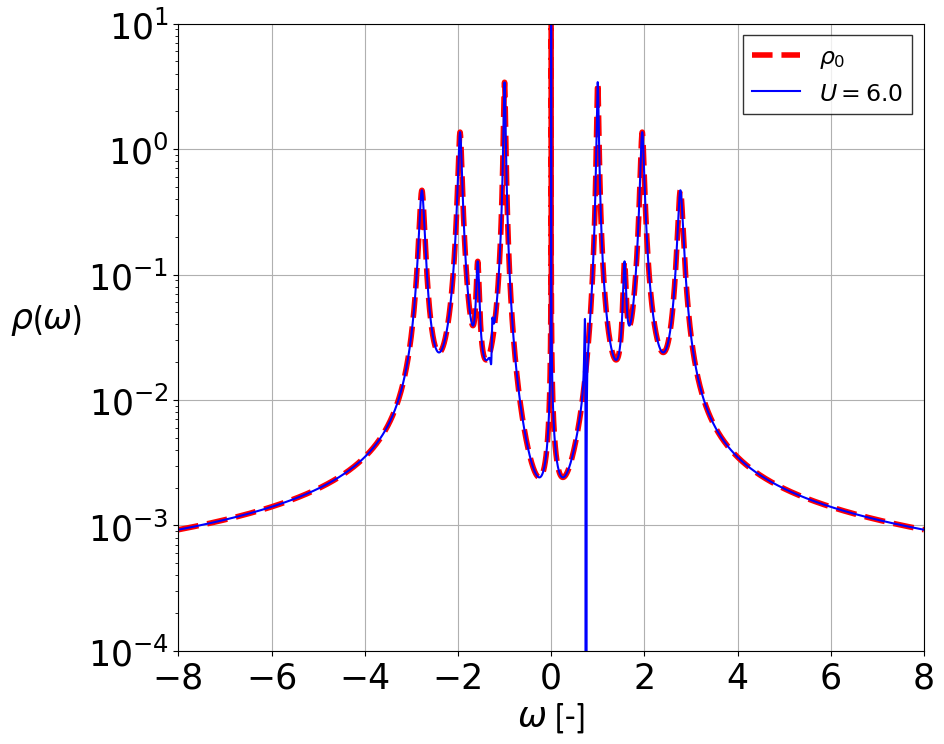

<module 'matplotlib.pyplot' from 'c:\\Users\\roelv\\OneDrive\\Documenten\\VSC\\.conda\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [24]:
input=[{"N" : 1, "poles" : 4, "U" : 0, "Sigma" : 0, "Ed" : 0, "ctype" : 'n', "bound" : 8, "eigsel" : False},
            {"N" : 2000, "poles" : 4, "U" : 0, "Sigma" : 0, "Ed" : 0, "ctype" : 'n', "bound" : 8, "eigsel" : True}]
radius,colorbnd,ip,nd,selecm=2.3,19,9,np.zeros((5,4,2),dtype = 'float'),['','eigval']
filenames,labelnames='GrapheneCirc'+str(radius)+'r6U','$\it{U=6.0}$'
DOST=np.zeros((1,20000),dtype = 'float')
psi,SPG,eig,SPrho0=GrapheneAnalyzer(ip,Graphenecirclestruct(radius,1),colorbnd,'GrapheneCirc'+str(radius)+'r')        
#if j==1: inp[i]['Edcalc']='AS'
#else: inp[i]['Edcalc']=''
nd[0,0], AvgSigmadat, DOST[0], nonintrho, omega, selectpT, selectpcT,tsim=Graphene_main(psi,SPG,eig,SPrho0,**input[0],posb=0)
DOSplot(DOST[0], nonintrho, omega,filenames+selecm[0],labelnames,log=True)

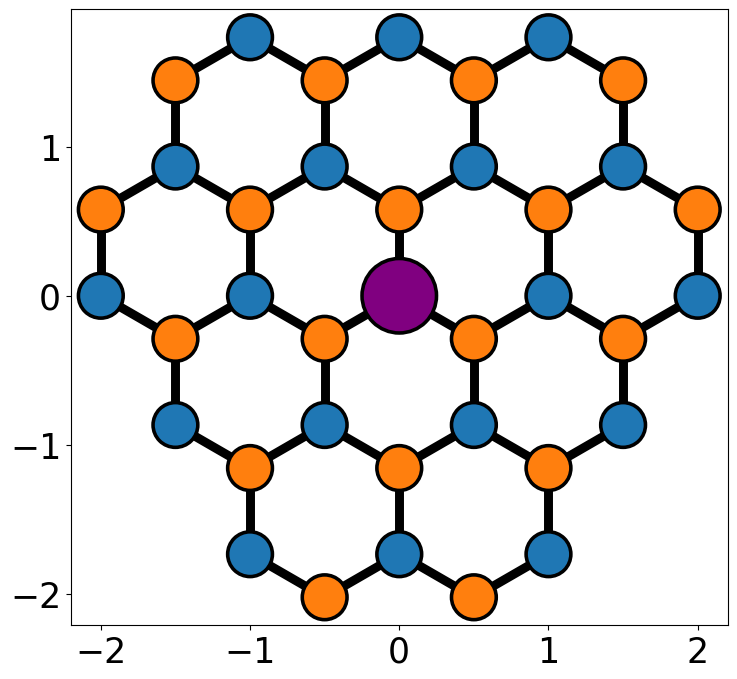

Iterations:   0%|          | 0/200000 [00:00<?, ?it/s]

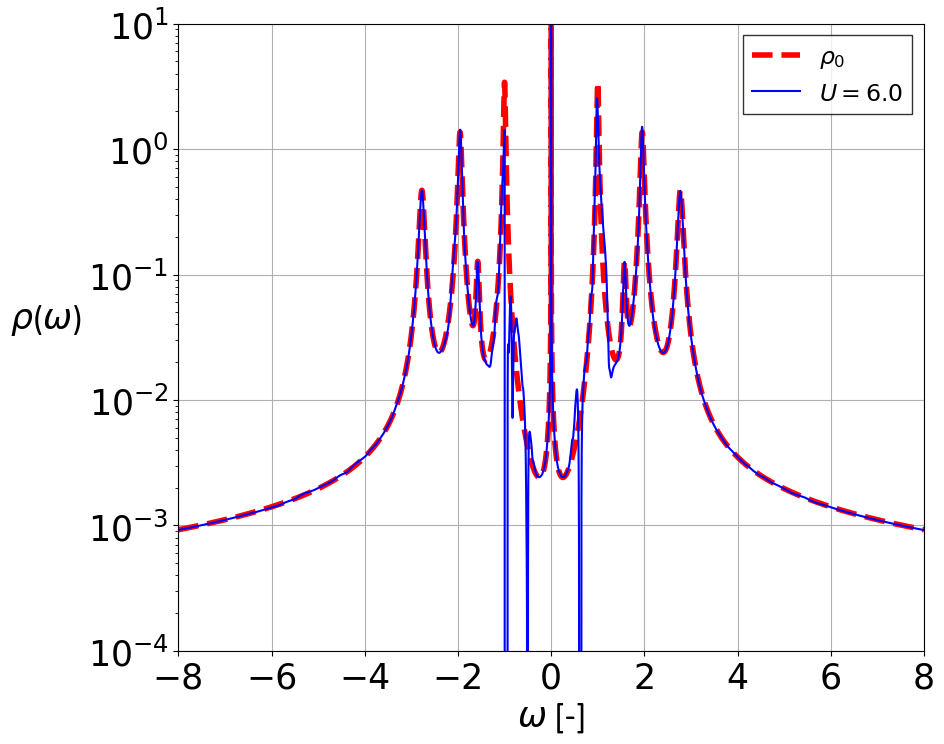

<module 'matplotlib.pyplot' from 'c:\\Users\\roelv\\OneDrive\\Documenten\\VSC\\.conda\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [19]:
input=[{"N" : 200000, "poles" : 4, "U" : 0, "Sigma" : 0, "Ed" : 0, "ctype" : 'n', "bound" : 8, "eigsel" : False},
            {"N" : 2000, "poles" : 4, "U" : 0, "Sigma" : 0, "Ed" : 0, "ctype" : 'n', "bound" : 8, "eigsel" : True}]
radius,colorbnd,ip,nd,selecm=2.3,19,9,np.zeros((5,4,2),dtype = 'float'),['','eigval']
filenames,labelnames='GrapheneCirc'+str(radius)+'r6U','$\it{U=6.0}$'
DOST=np.zeros((1,20000),dtype = 'float')
psi,SPG,eig,SPrho0=GrapheneAnalyzer(ip,Graphenecirclestruct(radius,1),colorbnd,'GrapheneCirc'+str(radius)+'r')        
#if j==1: inp[i]['Edcalc']='AS'
#else: inp[i]['Edcalc']=''
nd[0,0], AvgSigmadat, DOST[0], nonintrho, omega, selectpT, selectpcT,tsim=Graphene_main(psi,SPG,eig,SPrho0,**input[0],posb=0)
DOSplot(DOST[0], nonintrho, omega,filenames+selecm[0],labelnames,log=True)        

Iterations:   0%|          | 0/2000 [00:00<?, ?it/s]

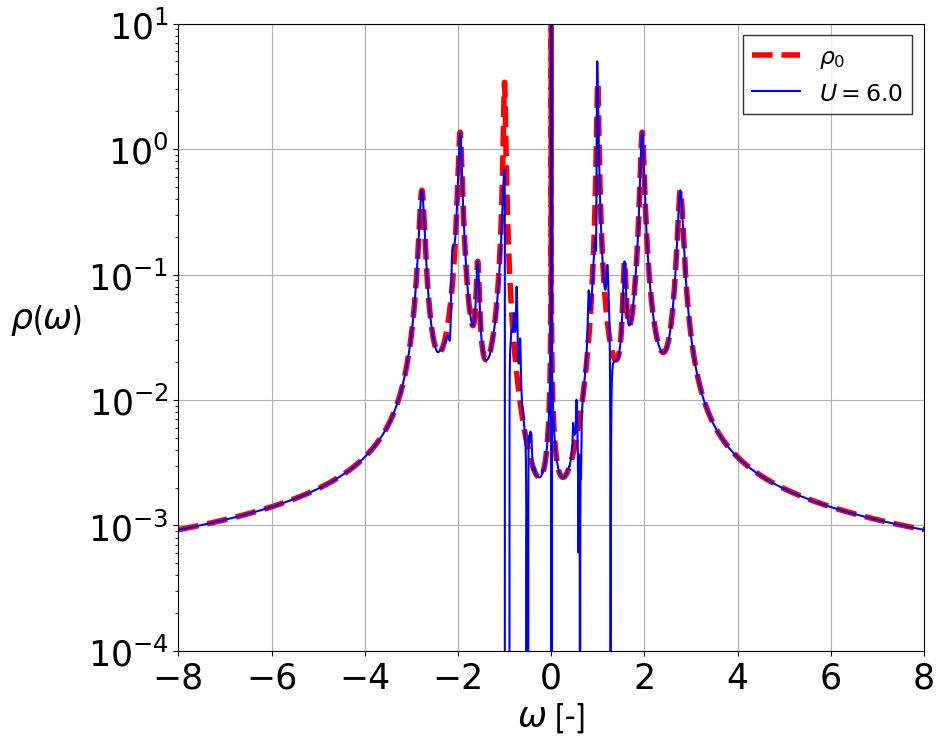

<module 'matplotlib.pyplot' from 'c:\\Users\\roelv\\OneDrive\\Documenten\\VSC\\.conda\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [20]:
nd[0,0], AvgSigmadat, DOST[0], nonintrho, omega, selectpT, selectpcT,tsim=Graphene_main(psi,SPG,eig,SPrho0,**input[1],posb=0)
DOSplot(DOST[0], nonintrho, omega,filenames+selecm[0],labelnames,log=True)    

In [ ]:
input=[[{"N" : 2000, "poles" : 4, "U" : 1.5, "Sigma" : 0.75, "Ed" : -1.5/2, "ctype" : 'n', "bound" : 8, "eigsel" : False},
            {"N" : 2000, "poles" : 4, "U" : 3.0, "Sigma" : 1.5, "Ed" : -3/2, "ctype" : 'n', "bound" : 8, "eigsel" : False},
            {"N" : 2000, "poles" : 4, "U" : 4.5, "Sigma" : 2.25, "Ed" : -4.5/2, "ctype" : 'n', "bound" : 8, "eigsel" : False},
            {"N" : 2000, "poles" : 4, "U" : 6.0, "Sigma" : 3.0, "Ed" : -6/2, "ctype" : 'n', "bound" : 8, "eigsel" : False}],
            [{"N" : 2000, "poles" : 4, "U" : 1.5, "Sigma" : 0.75, "Ed" : -1.5/2, "ctype" : 'n', "bound" : 8, "eigsel" : True},
            {"N" : 2000, "poles" : 4, "U" : 3.0, "Sigma" : 1.5, "Ed" : -3/2, "ctype" : 'n', "bound" : 8, "eigsel" : True},
            {"N" : 2000, "poles" : 4, "U" : 4.5, "Sigma" : 2.25, "Ed" : -4.5/2, "ctype" : 'n', "bound" : 8, "eigsel" : True},
            {"N" : 2000, "poles" : 4, "U" : 6.0, "Sigma" : 3.0, "Ed" : -6/2, "ctype" : 'n', "bound" : 8, "eigsel" : True}]]
#'AS'
l=0
inp=input[l]
radius,colorbnd,ip,nd,selecm=[1.5,2.3,3.1,4.042,5.1],[7,19,37,61,91],[3,9,18,30,45],np.zeros((5,4),dtype = 'float'),['','eigval']
j=1
r=radius[j]
filenames,labelnames=['GrapheneCirc'+str(r)+'r1_5U','GrapheneCirc'+str(r)+'r3U','GrapheneCirc'+str(r)+'r4_5U','GrapheneCirc'+str(r)+'r6U'],['$\it{U=1.5}$','$\it{U=3.0}$','$\it{U=4.5}$','$\it{U=6.0}$']
DOST=np.zeros((len(filenames),20000),dtype = 'float')
psi,SPG,eig,SPrho0=DEDliblog.GrapheneAnalyzer(ip[j],DEDliblog.Graphenecirclestruct(r,1),colorbnd[j],'GrapheneCirc'+str(r)+'r')
i=3
file=filenames[i]
if j==1:
    inp[i]['ctype'],inp[i]['Ed']='dn','AS'
else: inp[i]['ctype'],inp[i]['Ed']='n',-inp[i]['U']/2
nd[j,i], AvgSigmadat, DOST[i], nonintrho, omega, selectpT, selectpcT=DEDliblog.Graphene_main(psi,SPG,eig,SPrho0,**inp[i])
DEDliblog.DOSplot(DOST[i], nonintrho, omega,file+selecm[l],labelnames[i],log=True)
DEDliblog.textfileW(omega,np.ravel(selectpT),np.ravel(selectpcT),DOST[i],file+selecm[l])